In [1]:
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from modules import train_model, test_model
from dataset import BPDataset
from torch import optim
from torch.optim import lr_scheduler
from datetime import datetime
import pandas as pd
from backbone_models import ResNet18, VGG16
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
ppg_dir = '/Users/yeseullee/Documents/ECE271B/PPGBPDatabase/Data File/0_subject'
label_path = '/Users/yeseullee/Documents/ECE271B/PPGBPDatabase/Data File/PPG-BP dataset.csv'

In [3]:
# setup data loader
dataset = BPDataset(ppg_dir, label_path)
print('dataset: {}'.format(dataset.__len__()))

# Split training data, validation data, testing data
data_train, data_val, data_test = torch.utils.data.random_split(dataset, [415, 104, 129])
print(data_train.__len__())
print(data_val.__len__())
print(data_test.__len__())

{'Stage 1 hypertension', 'Stage 2 hypertension', 'Normal', 'Prehypertension'}
dataset: 648
415
104
129


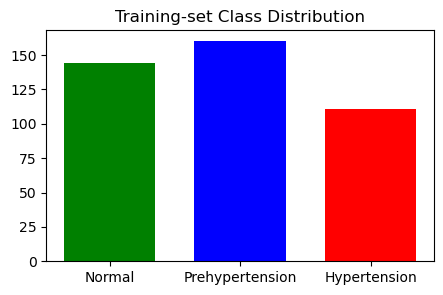

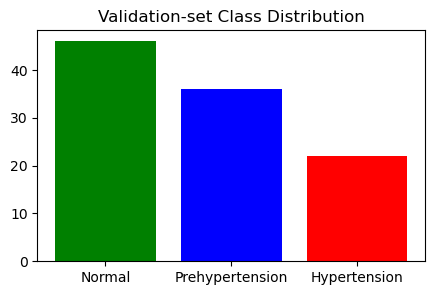

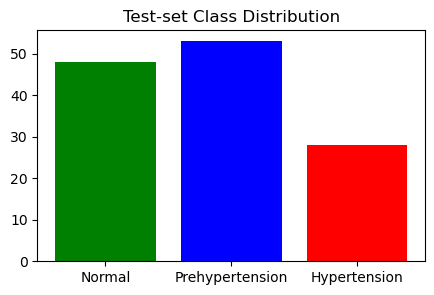

In [4]:
temp_dataloaders={'train': torch.utils.data.DataLoader(data_train,batch_size=1,shuffle=False),
                'val':torch.utils.data.DataLoader(data_val,batch_size=1,shuffle=False),
                'test':torch.utils.data.DataLoader(data_test,batch_size=1,shuffle=False)}

train_labels=[0,0,0]
for data, label, subject in temp_dataloaders['train']:
    if label.data==0:
        train_labels[0]+=1
    elif label.data==1:
        train_labels[1]+=1
    else:
        train_labels[2]+=1

plt.figure(figsize=(5,3))
plt.bar(np.arange(3),train_labels,color=['g','b','r'],width=0.7)
plt.xticks(np.arange(3),['Normal','Prehypertension','Hypertension'])
plt.title('Training-set Class Distribution')
plt.show()

val_labels=[0,0,0]
for data, label, subject in temp_dataloaders['val']:
    if label.data==0:
        val_labels[0]+=1
    elif label.data==1:
        val_labels[1]+=1
    else:
        val_labels[2]+=1

plt.figure(figsize=(5,3))
plt.bar(np.arange(3),val_labels,color=['g','b','r'])
plt.xticks(np.arange(3),['Normal','Prehypertension','Hypertension'])
plt.title('Validation-set Class Distribution')
plt.show()

test_labels=[0,0,0]
for data, label, subject in temp_dataloaders['test']:
    if label.data==0:
        test_labels[0]+=1
    elif label.data==1:
        test_labels[1]+=1
    else:
        test_labels[2]+=1

plt.figure(figsize=(5,3))
plt.bar(np.arange(3),test_labels,color=['g','b','r'])
plt.xticks(np.arange(3),['Normal','Prehypertension','Hypertension'])
plt.title('Test-set Class Distribution')
plt.show()


In [5]:
dataloaders={'train': torch.utils.data.DataLoader(data_train,batch_size=10,shuffle=True),
                'val':torch.utils.data.DataLoader(data_val,batch_size=10,shuffle=True),
                'test':torch.utils.data.DataLoader(data_test,batch_size=10,shuffle=False)}
dataset_sizes = {'train': data_train.__len__(),
                    'val':data_val.__len__(),
                    'test':data_test.__len__()}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:',device)

Device: cpu


In [7]:
model=ResNet18(3)
model=model.to(device)

In [ ]:
learning_rate=0.0001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)
trained_model,trained_model_later=train_model(model, criterion, optimizer, exp_lr_scheduler, dataloaders, dataset_sizes, device, num_epochs=50)

Epoch 0/49
----------
train Loss: 1.1123 Acc: 0.3855
val Loss: 1.0413 Acc: 0.4423

Epoch 1/49
----------
train Loss: 1.0881 Acc: 0.3807
val Loss: 1.0433 Acc: 0.4135

Epoch 2/49
----------
train Loss: 1.0612 Acc: 0.4072
val Loss: 1.0158 Acc: 0.4327

Epoch 3/49
----------
train Loss: 1.0426 Acc: 0.4386
val Loss: 1.0259 Acc: 0.4135

Epoch 4/49
----------
train Loss: 1.0414 Acc: 0.4361
val Loss: 1.0051 Acc: 0.4038

Epoch 5/49
----------
train Loss: 1.0246 Acc: 0.4651
val Loss: 1.0293 Acc: 0.3942

Epoch 6/49
----------
train Loss: 1.0152 Acc: 0.4627
val Loss: 1.0102 Acc: 0.4327

Epoch 7/49
----------
train Loss: 0.9826 Acc: 0.5325
val Loss: 1.0436 Acc: 0.4135

Epoch 8/49
----------
train Loss: 0.9503 Acc: 0.5639
val Loss: 1.1352 Acc: 0.3654

Epoch 9/49
----------
train Loss: 0.9216 Acc: 0.5518
val Loss: 1.1034 Acc: 0.3846

Epoch 10/49
----------
train Loss: 0.7771 Acc: 0.6434
val Loss: 1.1671 Acc: 0.3942

Epoch 11/49
----------
train Loss: 0.6238 Acc: 0.7759
val Loss: 1.1674 Acc: 0.4327

Ep